In [1]:
# Подготовка
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

import zipfile


__z = zipfile.ZipFile("dataset.zip")
#df_str = __z.open("Vehicle_policies_2020.csv").read().decode("utf-8")
df_str_fs = __z.open("car_price_prediction.csv")

df_src = pd.read_csv(df_str_fs)


# Предварительная обработка данных

Данные [отсюда](https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge):

~~1. ID: индификатор продажи. ~~

2. Price: цена машины (этот столбец будем предсказывать). 

3. Levy: налог. 

4. Manufacturer: производитель. 

5. Model: модель машины. 

6. Prod. year: год производства. 

7. Category: тип машины. 

8. Leather interior: есть ли кожанный салон. 

9. Fuel type: тип топлива/тип двигателя. 

10. Engine volume: рабочий объём двигателя. 

11. Mileage: пробег. 

12. Cylinders: количество цилиндров. 

13. Gear box type: тип коробки передач. 

14. Drive wheels: ведущее(ие) колес(а). 

15. Doors: двери. 

16. Wheel: расположение руля (слева или справа). 

17. Color: цвет. 

18. Airbags: количество подушек безопасности. 


In [2]:
# Look dataframe
pd.set_option('display.max_columns', df_src.shape[1])
df_src.head(300)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,45793908,4924,1282,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,183923 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
296,45763993,4704,-,OPEL,Vectra b,2000,Hatchback,No,Diesel,2.0 Turbo,11111 km,4.0,Manual,Front,04-May,Left wheel,Red,2
297,45731752,43576,1091,HYUNDAI,H1,2016,Universal,Yes,Diesel,2.5,97129 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
298,45725280,7840,-,MERCEDES-BENZ,C 200,2001,Sedan,Yes,CNG,2,140000 km,4.0,Manual,Rear,04-May,Left wheel,Black,4


In [3]:
# Look dataframe
#df_src.head()
pd.set_option('display.max_columns', df_src.shape[1])
df_src.tail(300)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
18937,45768700,941,746,TOYOTA,Prius,2009,Sedan,Yes,Hybrid,1.5,433658 km,4.0,Automatic,Front,04-May,Left wheel,White,12
18938,45809477,42538,784,HONDA,FIT,2017,Hatchback,Yes,Petrol,1.5,9000 km,4.0,Automatic,Front,04-May,Left wheel,Black,4
18939,45794536,7300,-,BMW,318,1999,Sedan,No,Petrol,1.9,257000 km,4.0,Manual,Rear,04-May,Left wheel,Blue,6
18940,45802794,20764,642,HYUNDAI,Santa FE,2012,Jeep,Yes,Diesel,2,198966 km,4.0,Automatic,Front,04-May,Left wheel,White,4
18941,45809093,96263,866,FORD,Mustang,2015,Sedan,Yes,Petrol,2.3,43770 km,4.0,Automatic,Front,04-May,Left wheel,White,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


# Проектирование признаков

## Убираем дубликаты

In [4]:
print(f"Number of (rows, columns): {df_src.shape}")
duplicate_rows_df = df_src[df_src.duplicated()]
print(f"Number of duplicate (rows, columns): {duplicate_rows_df.shape}")
df_src = df_src.drop_duplicates()
print(f"Number of (rows, columns) after drop dublicates: {df_src.shape}")

Number of (rows, columns): (19237, 18)
Number of duplicate (rows, columns): (313, 18)
Number of (rows, columns) after drop dublicates: (18924, 18)


## Смотрим, чтобы не было нерелевантных данных

### Как поступить с такими данными?

![](./imgs/if_missing_data.png)


In [5]:
pd.set_option('display.max_rows', df_src.shape[1])
df_src.count() # Кол-во не None значений в каждой колонке

ID                  18924
Price               18924
Levy                18924
Manufacturer        18924
Model               18924
Prod. year          18924
Category            18924
Leather interior    18924
Fuel type           18924
Engine volume       18924
Mileage             18924
Cylinders           18924
Gear box type       18924
Drive wheels        18924
Doors               18924
Wheel               18924
Color               18924
Airbags             18924
dtype: int64

In [6]:
pd.set_option('display.max_rows', df_src.shape[1])
print(df_src.isnull().sum()) # Смотрим есть ли null хотя бы в каком-нибудь столбце


ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


False    13215
True      5709
Name: Levy, dtype: int64
False    0.69832
True     0.30168
Name: Levy, dtype: float64

	For example if levy exists for HONDA FIT: 218 peaces. 

	For example if levy not exists for HONDA FIT: 226 peaces. 


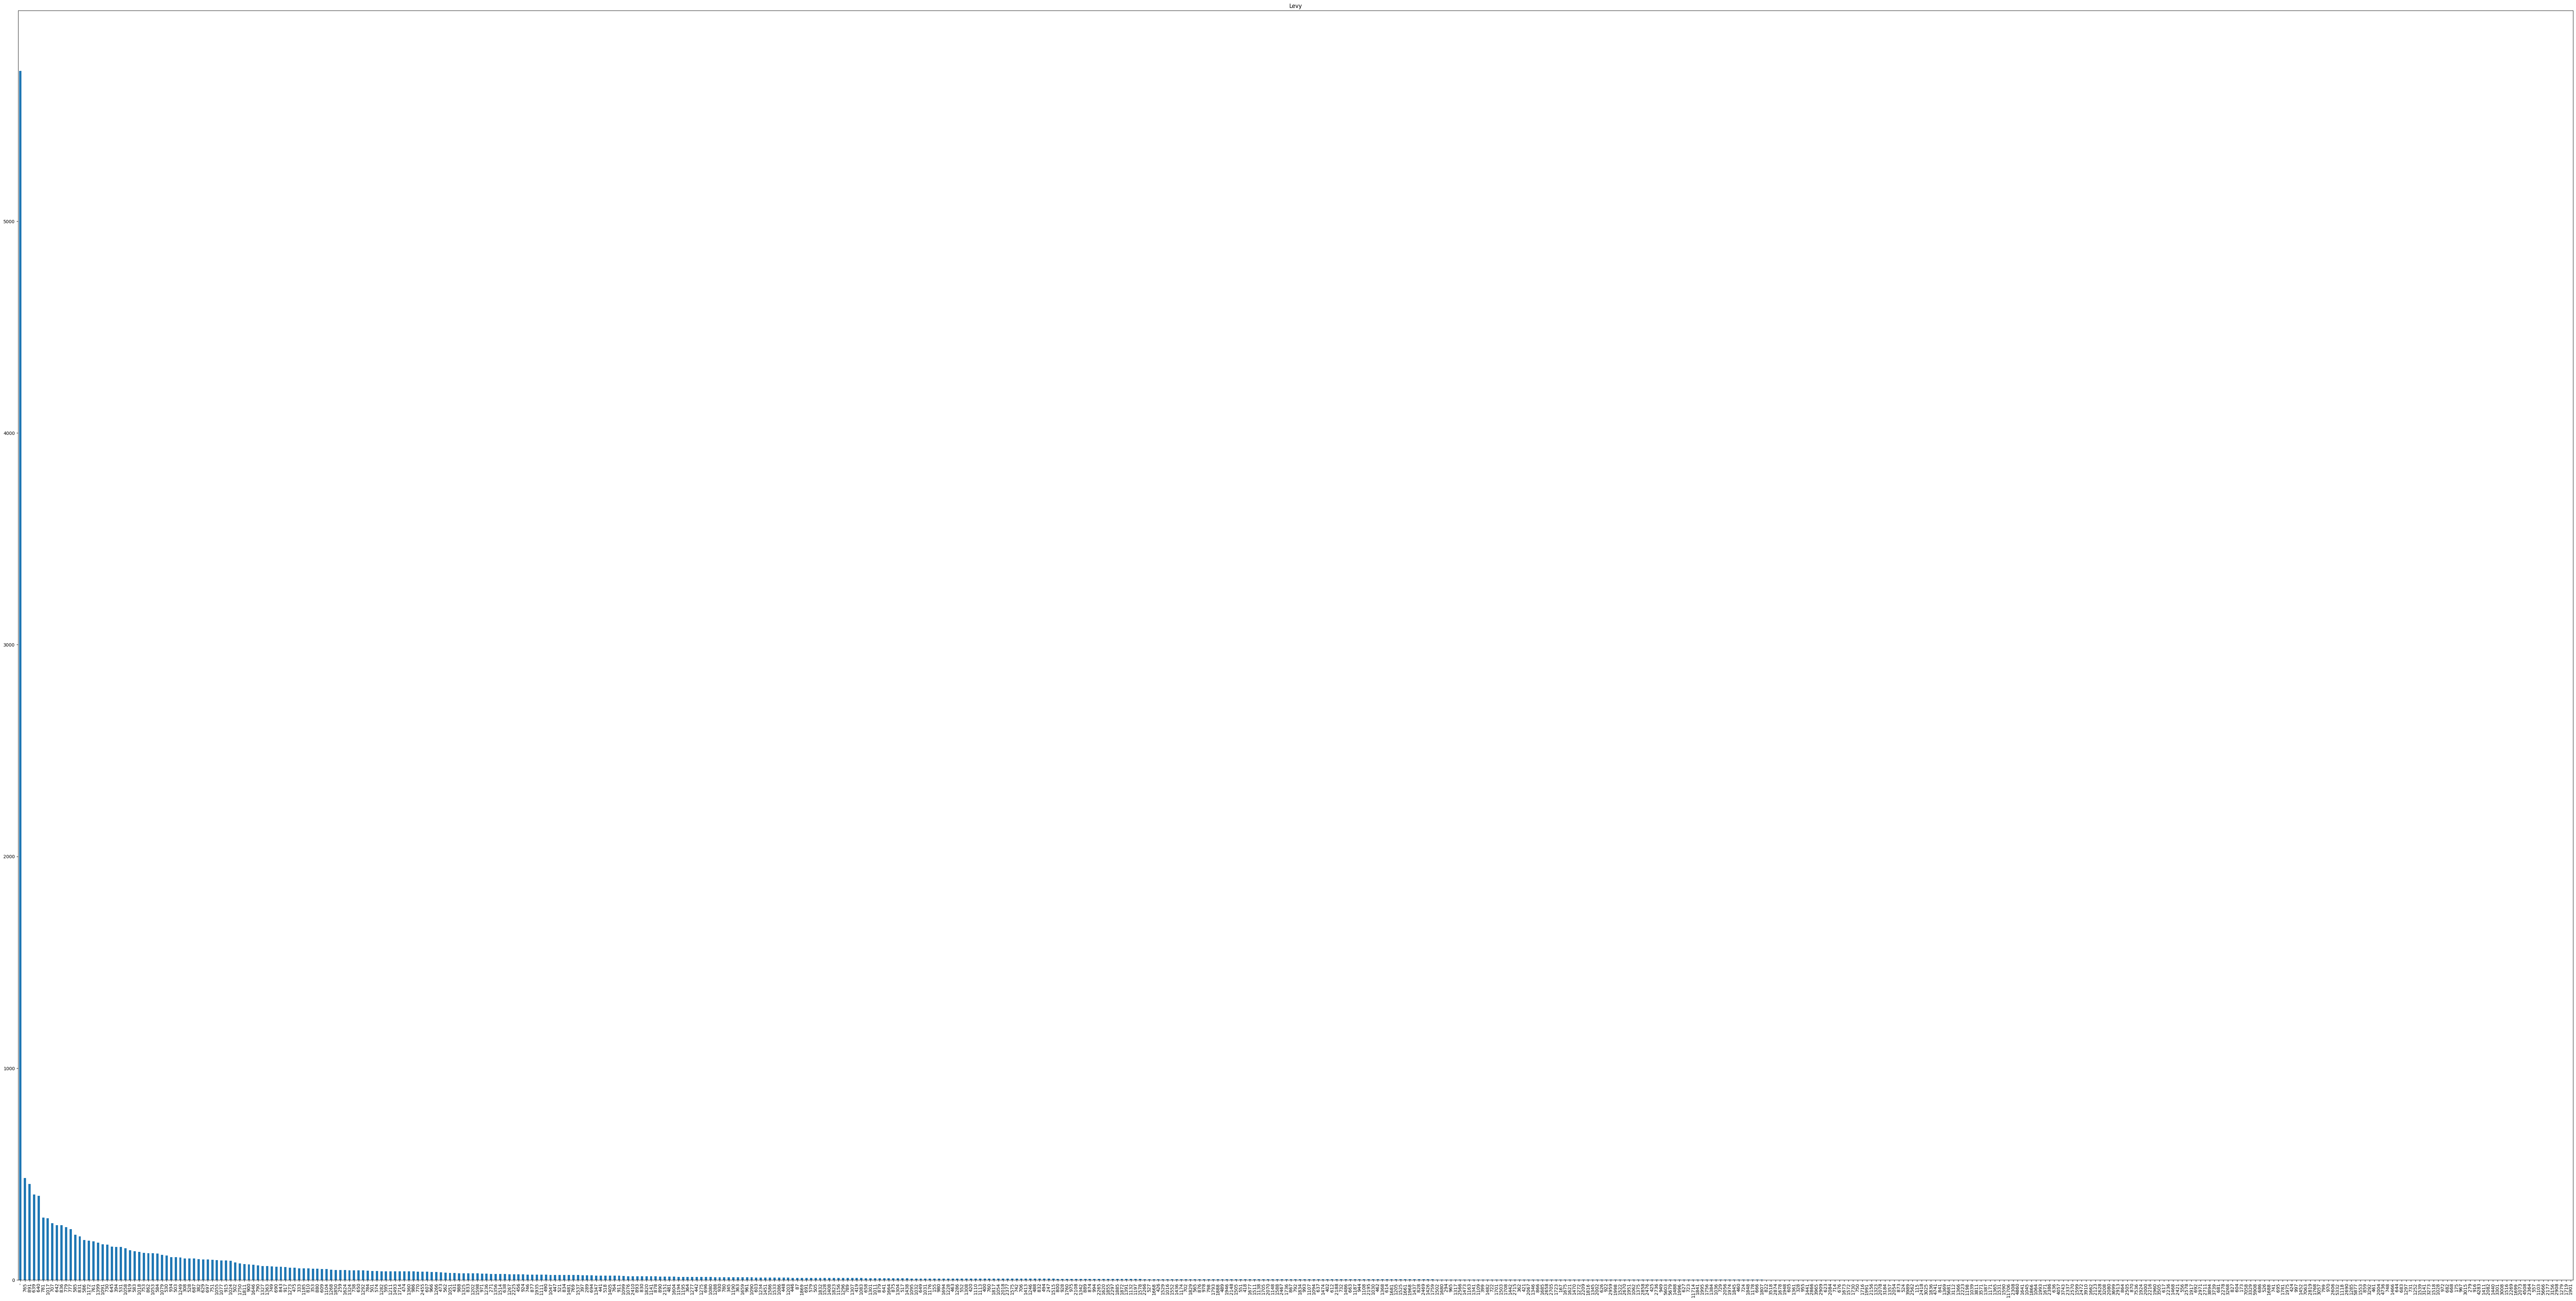

In [7]:
plt.figure(figsize=(100,50))

print((df_src["Levy"] == "-").value_counts())
print((df_src["Levy"] == "-").value_counts(normalize=True))

(df_src["Levy"]).value_counts().plot(kind='bar', subplots=True)


levy_fit_true = df_src[(df_src["Levy"] != "-") & (df_src["Model"] == "FIT") & (df_src["Manufacturer"] == "HONDA")].shape[0]

levy_fit_false = df_src[(df_src["Levy"] == "-") & (df_src["Model"] == "FIT") & (df_src["Manufacturer"] == "HONDA")].shape[0]

print(f"\n\tFor example if levy exists for HONDA FIT: {levy_fit_true} peaces. ")
print(f"\n\tFor example if levy not exists for HONDA FIT: {levy_fit_false} peaces. ")

# df_src.hist(column="Levy")

# print(f"Range of Levy: [{df_src['Levy'].min()} - {df_src['Levy'].max()}]")


In [8]:
IF_Levy_DELETE = False

if(IF_Levy_DELETE == True):
    # Удалим посностью Levy
    del df_src["Levy"]
else:
    # ИЛИ Удалим Levy, где равен "-"
    df_src = df_src.drop(df_src[df_src["Levy"] == "-"].index)


/tmp/ipykernel_21564/161341565.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_src["Price"])


<AxesSubplot: xlabel='Price', ylabel='Density'>

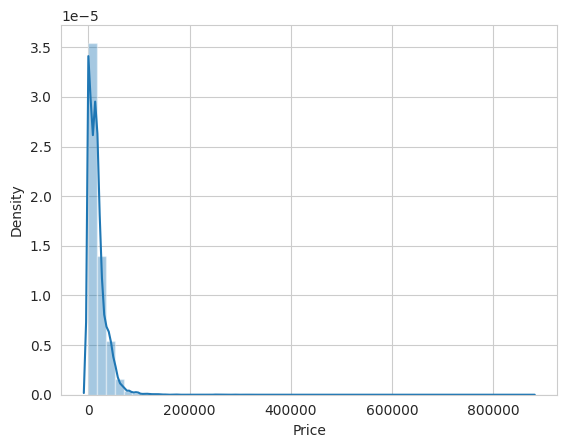

In [9]:
sns.set_style('whitegrid')
sns.distplot(df_src["Price"])

/tmp/ipykernel_21564/305833953.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(   df_src[    (df_src["Price"]<75000)&(df_src["Price"]>0)   ]["Price"]   )
/tmp/ipykernel_21564/305833953.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(   df_src[    (df_src["Price"]<30000)&(df_src["Price"]>

Range of Price: [1 - 872946]


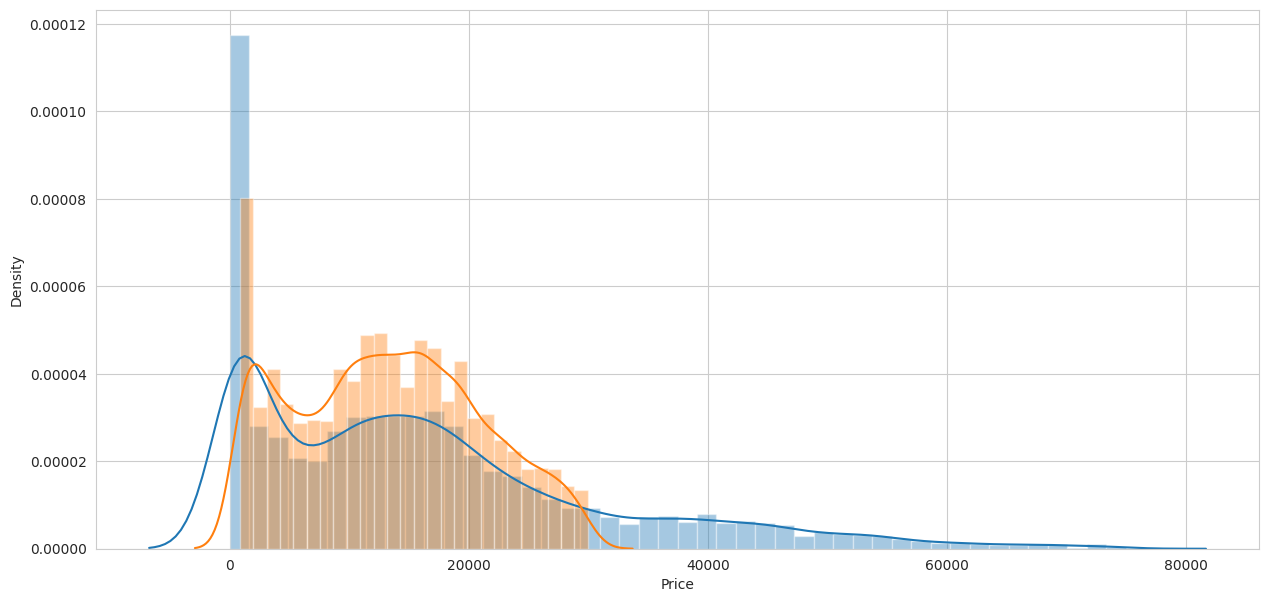

In [10]:

fig,ag = plt.subplots(figsize=(15,7))
sns.distplot(   df_src[    (df_src["Price"]<75000)&(df_src["Price"]>0)   ]["Price"]   )
sns.distplot(   df_src[    (df_src["Price"]<30000)&(df_src["Price"]>850)   ]["Price"]   )
print(f"Range of Price: [{df_src['Price'].min()} - {df_src['Price'].max()}]")

In [11]:
# Мда, создатель датасета, видимо решил приколоться...

IF_shit_DELETE = False

if(IF_shit_DELETE == True):
    # Удалим машины ниже 850 долларов
    df_src = df_src.drop(df_src[df_src["Price"] < 850].index)
else:
    # ИЛИ оставляем всё как есть и веселимся!
    pass

In [12]:
# Удалим посностью ID
del df_src["ID"]

# Удалим null'ы
df_src = df_src.dropna()

# Удалим дубликаты, если они появились после удаления столбцов
df_src = df_src.drop_duplicates()

print(f"\nNumber of (rows, columns): {df_src.shape}")

print("\nКол-во не None значений:")
print(df_src.count())

print("\nКол-во null\'ов:")
print(df_src.isnull().sum())


Number of (rows, columns): (10041, 17)

Кол-во не None значений:
Price               10041
Levy                10041
Manufacturer        10041
Model               10041
Prod. year          10041
Category            10041
Leather interior    10041
Fuel type           10041
Engine volume       10041
Mileage             10041
Cylinders           10041
Gear box type       10041
Drive wheels        10041
Doors               10041
Wheel               10041
Color               10041
Airbags             10041
dtype: int64

Кол-во null'ов:
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


## Кодирование строк + числа - это числа

In [13]:
# Смотрим типы столбцов

pd.set_option('display.max_rows', df_src.shape[1])

nullout = '''
Должно быть:

Price                 int64
Levy                  int64
Manufacturer         cat->int
Model                cat->int
Prod. year            int64
Category             cat->int
Leather interior     cat->int
Fuel type            cat->int
Engine volume        float64
Mileage               int64
Cylinders           float64
Gear box type        cat->int
Drive wheels         cat->int
Doors                cat->int
Wheel                cat->int
Color                cat->int
Airbags               int64
'''

df_src.dtypes

Price                 int64
Levy                 object
Manufacturer         object
Model                object
Prod. year            int64
Category             object
Leather interior     object
Fuel type            object
Engine volume        object
Mileage              object
Cylinders           float64
Gear box type        object
Drive wheels         object
Doors                object
Wheel                object
Color                object
Airbags               int64
dtype: object

In [14]:
# Избавимся от мусора, сделаем числа числами

print(df_src["Levy"].value_counts())
df_src["Levy"] = df_src["Levy"].astype(int)

print("\n==========\n")

print(df_src["Mileage"].value_counts())
df_src["Mileage"] = df_src["Mileage"].apply(lambda x: x.split(" ")[0])
df_src["Mileage"] = df_src["Mileage"].astype(int)

print("\n==========\n")

print(df_src["Engine volume"].value_counts())
df_src["Engine volume"] = df_src["Engine volume"].apply(lambda x: x.split(" ")[0])
df_src["Engine volume"] = df_src["Engine volume"].astype(float)


891     387
765     387
639     340
640     336
642     245
       ... 
2177      1
5666      1
3156      1
1719      1
1901      1
Name: Levy, Length: 558, dtype: int64


0 km         253
90000 km      45
150000 km     41
120000 km     39
110000 km     38
            ... 
380070 km      1
66630 km       1
203770 km      1
80687 km       1
186923 km      1
Name: Mileage, Length: 6734, dtype: int64


2            2728
2.5          1239
1.8           971
1.6           890
1.5           694
             ... 
2.7 Turbo       1
20              1
2.9 Turbo       1
3.4             1
3.7 Turbo       1
Name: Engine volume, Length: 87, dtype: int64


In [15]:
cat_columns = ["Manufacturer", "Model", "Category", "Leather interior", "Fuel type", "Gear box type", "Drive wheels", "Wheel", "Color", "Doors"]

for col_i in cat_columns:
    print(f"\n==========\n{col_i}")
    print(df_src[col_i].value_counts())



Manufacturer
HYUNDAI          2825
TOYOTA           1820
CHEVROLET         911
FORD              587
MERCEDES-BENZ     521
                 ... 
LAMBORGHINI         1
BENTLEY             1
GAZ                 1
TESLA               1
HUMMER              1
Name: Manufacturer, Length: 49, dtype: int64

Model
Sonata          770
Elantra         647
Prius           524
Santa FE        475
Camry           459
               ... 
GLK 300           1
RAV 4 XLE         1
100 NX            1
A3 4X4            1
Prius C aqua      1
Name: Model, Length: 793, dtype: int64

Category
Sedan          4704
Jeep           3077
Hatchback      1417
Minivan         258
Coupe           223
Universal       181
Goods wagon      74
Microbus         70
Pickup           21
Cabriolet        16
Name: Category, dtype: int64

Leather interior
Yes    8134
No     1907
Name: Leather interior, dtype: int64

Fuel type
Petrol            5503
Diesel            2376
Hybrid            1636
LPG                467
Plug-in Hybr

In [16]:
df_nums = df_src.copy()

# Категориальные:

cat_columns_auto = ["Manufacturer", "Model", "Category", "Fuel type", "Color"]
cat_columns_man = {"Leather interior": {"No": 0, "Yes": 1}, 
                   "Gear box type": {"Manual": 0, "Automatic": 1, "Variator": 2, "Tiptronic": 3}, 
                   "Drive wheels": {"Rear": 0, "Front": 1, "4x4": 2}, 
                   "Wheel": {"Right-hand drive": 0, "Left wheel": 1}, 
                   "Doors": {"04-May": 0, "02-Mar": 1, ">5": 2}}

for col_i in cat_columns_auto:
    df_nums[col_i] = df_nums[col_i].astype('category')
    df_nums[col_i] = df_nums[col_i].cat.codes
    df_nums[col_i] = df_nums[col_i].astype(int)

for col_i in cat_columns_man:
    df_nums = df_nums.replace(cat_columns_man)

pd.set_option('display.max_rows', df_src.shape[1])
df_nums.dtypes

Price                 int64
Levy                  int64
Manufacturer          int64
Model                 int64
Prod. year            int64
Category              int64
Leather interior      int64
Fuel type             int64
Engine volume       float64
Mileage               int64
Cylinders           float64
Gear box type         int64
Drive wheels          int64
Doors                 int64
Wheel                 int64
Color                 int64
Airbags               int64
dtype: object

## Нормализация

In [17]:
df_nums_scaled = df_nums.copy()
buff = df_nums_scaled["Price"]
df_nums_scaled = ( df_nums-df_nums.min() ) / ( df_nums.max() - df_nums.min() )
del df_nums_scaled["Price"]
df_nums_scaled.insert(0, "Price", buff)
df_nums_scaled.head(300)


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,0.112841,0.541667,0.794192,0.818182,0.444444,1.0,0.4,0.175,0.000087,0.333333,0.333333,1.0,0.0,1.0,0.800000,0.75
1,16621,0.080072,0.125000,0.395202,0.836364,0.444444,0.0,0.8,0.150,0.000089,0.333333,1.000000,1.0,0.0,1.0,0.066667,0.50
3,3607,0.066655,0.291667,0.398990,0.836364,0.444444,1.0,0.4,0.125,0.000079,0.200000,0.333333,1.0,0.0,1.0,0.933333,0.00
4,11726,0.030876,0.354167,0.417929,0.890909,0.333333,1.0,0.8,0.065,0.000043,0.200000,0.333333,0.5,0.0,1.0,0.800000,0.25
5,39493,0.069149,0.395833,0.823232,0.927273,0.444444,1.0,0.2,0.100,0.000075,0.200000,0.333333,0.5,0.0,1.0,0.933333,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,21169,0.059689,0.125000,0.313131,0.963636,0.888889,0.0,0.8,0.070,0.000012,0.200000,0.333333,0.5,0.0,1.0,0.200000,0.50
417,7495,0.086265,0.125000,0.250000,0.781818,0.444444,1.0,0.2,0.100,0.000033,0.200000,0.333333,0.5,0.0,1.0,0.066667,0.25
418,4861,0.047992,0.541667,0.210859,0.836364,0.333333,1.0,0.4,0.090,0.000045,0.200000,0.333333,0.5,0.0,1.0,0.933333,0.75
419,13485,0.058313,0.395833,0.844697,0.909091,0.888889,1.0,0.6,0.100,0.000034,0.200000,0.333333,0.5,0.0,1.0,0.800000,0.25


# Графики

![](./imgs/which_visualization.png)


In [18]:
num_columns = ["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]
for col_i in num_columns:
    print(f"Range of {col_i}: [{df_nums[col_i].min()} - {df_nums[col_i].max()}]")

Range of Price: [1 - 872946]
Range of Levy: [87 - 11714]
Range of Prod. year: [1965 - 2020]
Range of Engine volume: [0.0 - 20.0]
Range of Mileage: [0 - 2147483647]
Range of Cylinders: [1.0 - 16.0]
Range of Airbags: [0 - 16]


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
Price,1.000000,0.081075,-0.039637,0.084986,0.300160,-0.109506,0.076761,-0.112007,0.106181,-0.004809,0.068014,0.149769,0.023917,-0.010171,0.079410,-0.012713,-0.164185
Levy,0.081075,1.000000,0.000712,-0.003441,-0.226092,-0.035341,-0.008585,0.061629,0.579051,0.027984,0.496426,-0.002452,0.065827,0.087261,-0.297309,-0.035328,0.083863
Manufacturer,-0.039637,0.000712,1.000000,-0.056769,-0.034497,-0.097756,-0.176542,-0.053017,-0.015269,-0.003994,-0.057616,0.082945,0.047835,-0.046161,-0.100346,0.000689,0.167300
Model,0.084986,-0.003441,-0.056769,1.000000,-0.003627,-0.139409,0.005880,-0.233382,0.047934,0.018972,-0.001483,-0.076915,0.147787,-0.055505,0.079663,0.061744,-0.124200
Prod. year,0.300160,-0.226092,-0.034497,-0.003627,1.000000,0.092512,0.169085,0.146592,-0.065427,-0.054543,-0.098084,0.070949,0.044446,-0.097841,0.070882,-0.019200,0.087603
Category,-0.109506,-0.035341,-0.097756,-0.139409,0.092512,1.000000,0.084951,0.240050,0.023483,0.001205,-0.055612,0.102882,-0.158293,-0.154597,0.124065,-0.015661,0.110729
Leather interior,0.076761,-0.008585,-0.176542,0.005880,0.169085,0.084951,1.000000,-0.049671,0.193499,-0.027288,0.131768,-0.139372,0.018435,-0.073652,0.282712,-0.026307,-0.001585
Fuel type,-0.112007,0.061629,-0.053017,-0.233382,0.146592,0.240050,-0.049671,1.000000,0.083754,-0.023285,0.121629,0.214567,0.061311,0.042601,0.005261,-0.101144,0.252880
Engine volume,0.106181,0.579051,-0.015269,0.047934,-0.065427,0.023483,0.193499,0.083754,1.000000,0.001080,0.720580,0.073018,0.201629,0.054257,0.154349,-0.084913,0.254506
Mileage,-0.004809,0.027984,-0.003994,0.018972,-0.054543,0.001205,-0.027288,-0.023285,0.001080,1.000000,-0.004450,-0.023372,-0.002352,0.048687,0.002547,0.008785,-0.013911


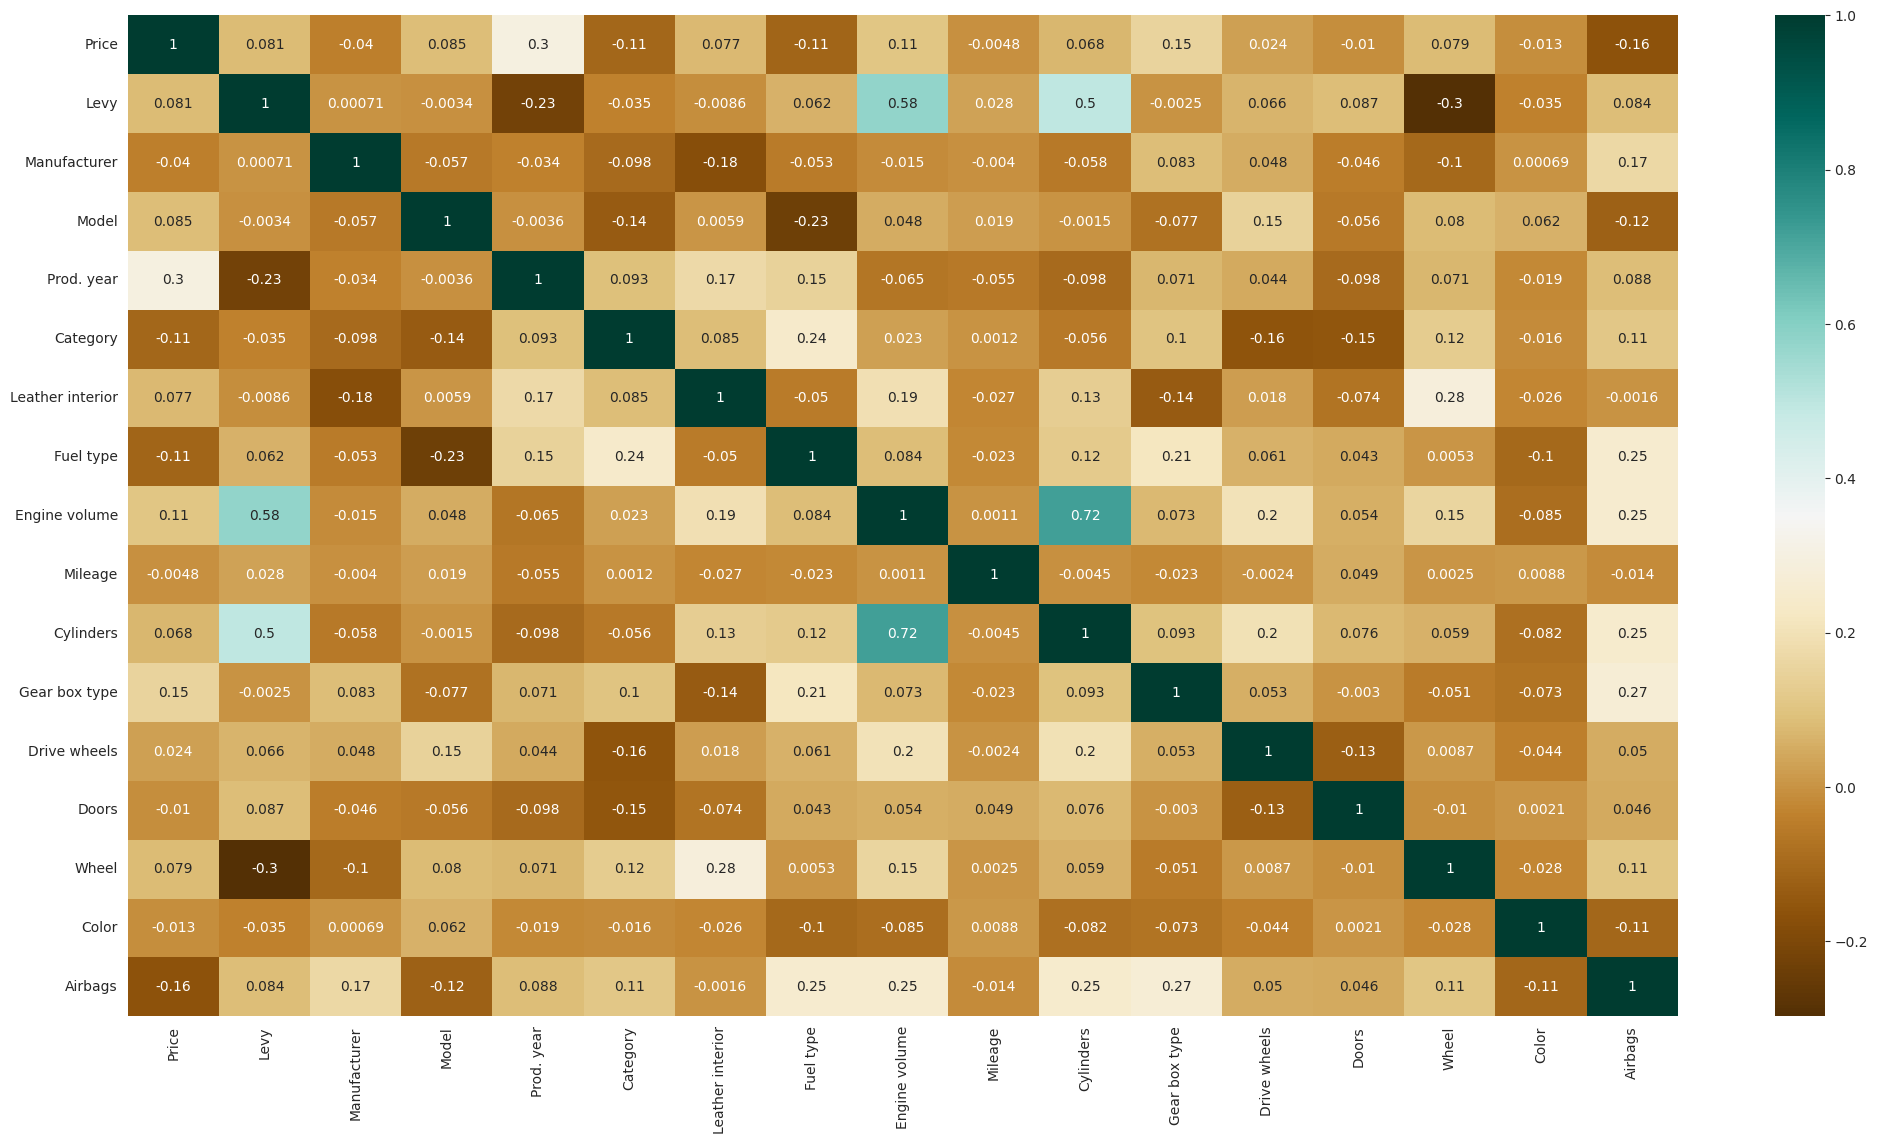

In [19]:
# Тепловая карта

plt.figure(figsize=(25, 13))
c= df_nums.corr()
sns.heatmap(c, cmap="BrBG", annot=True)
c

# Смотря на карту эту, невольно спрашиваешь: А почему предсказываем Price? Куда интереснее выглядит Levy

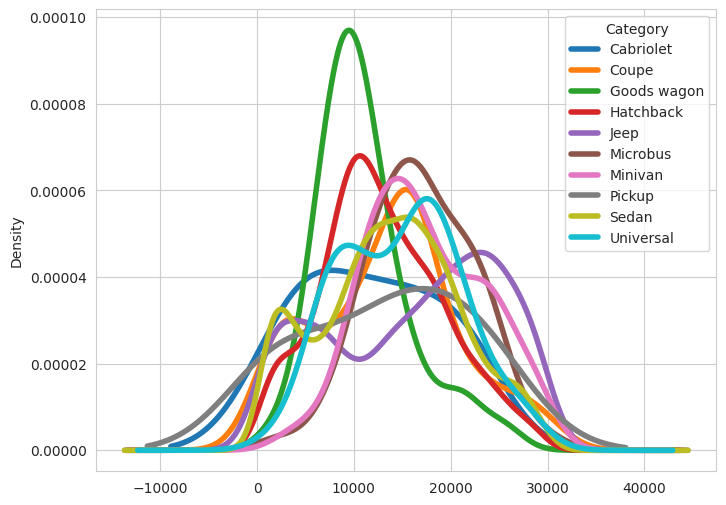

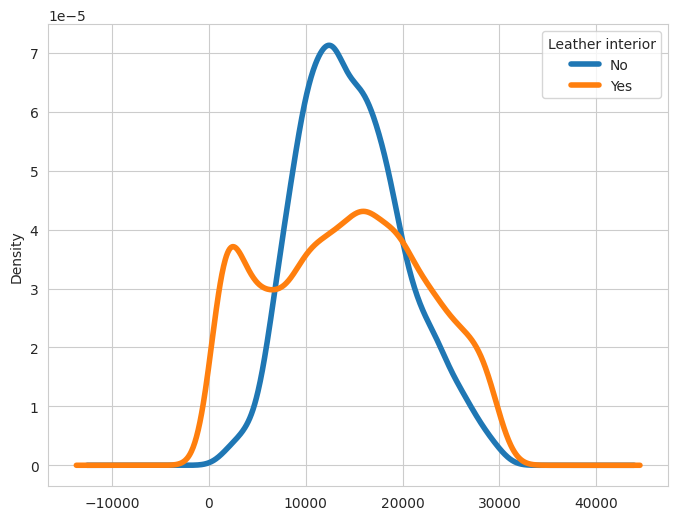

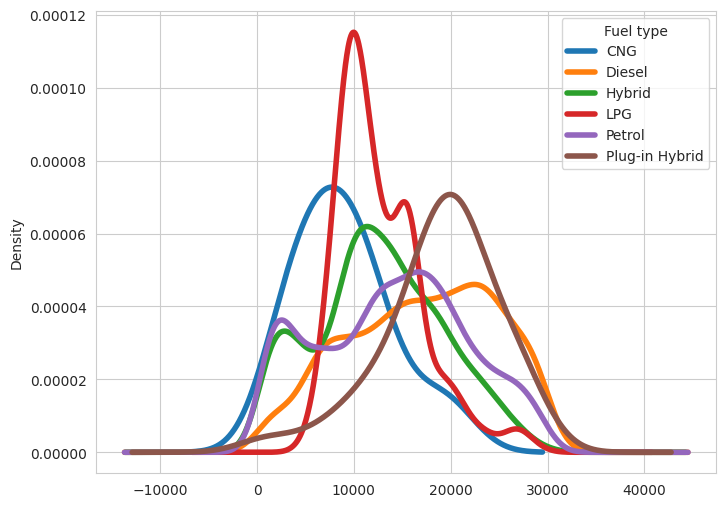

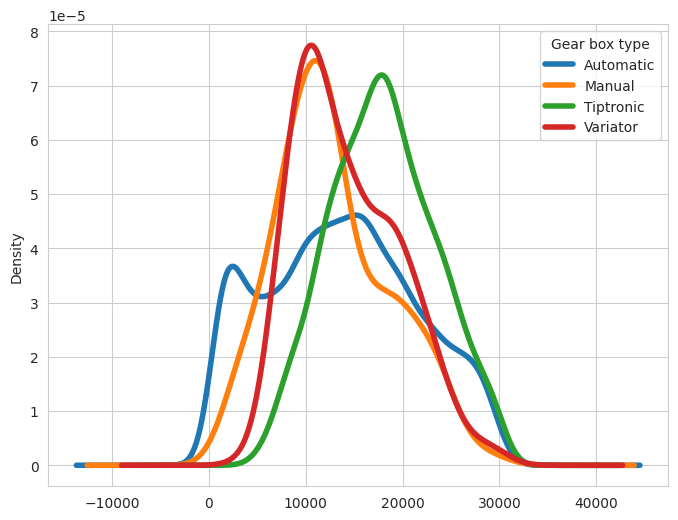

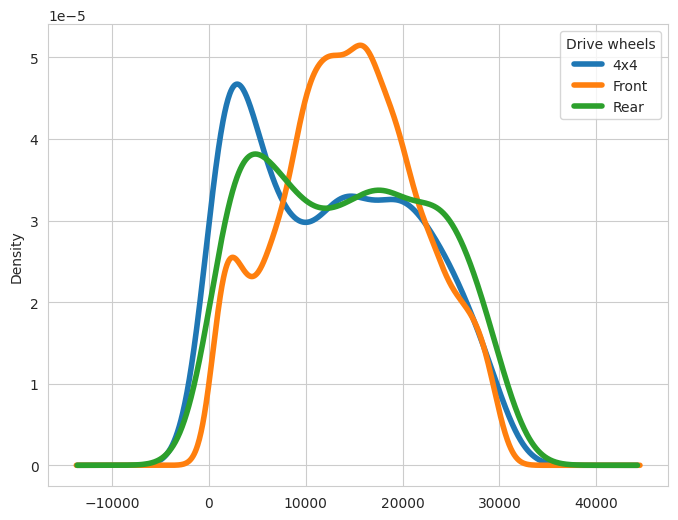

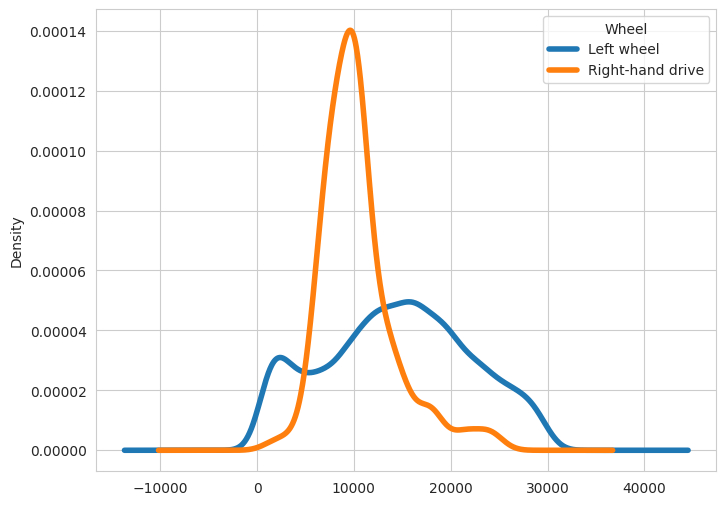

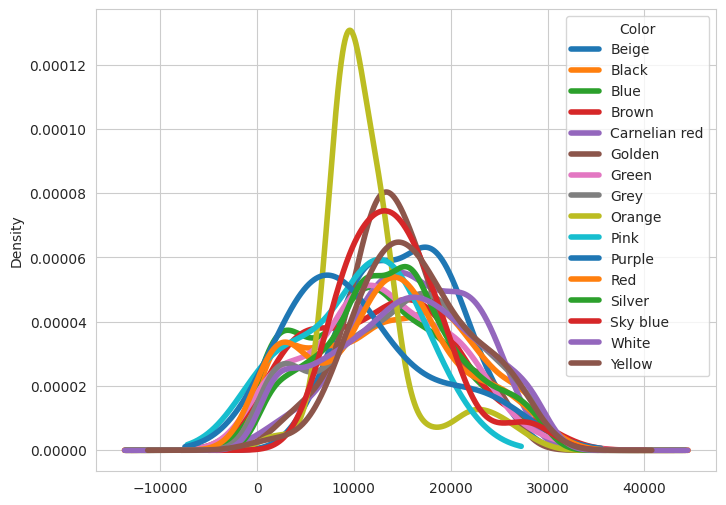

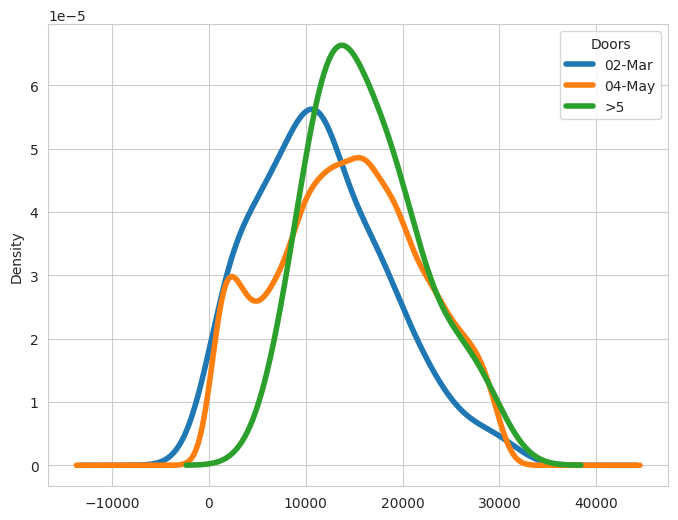

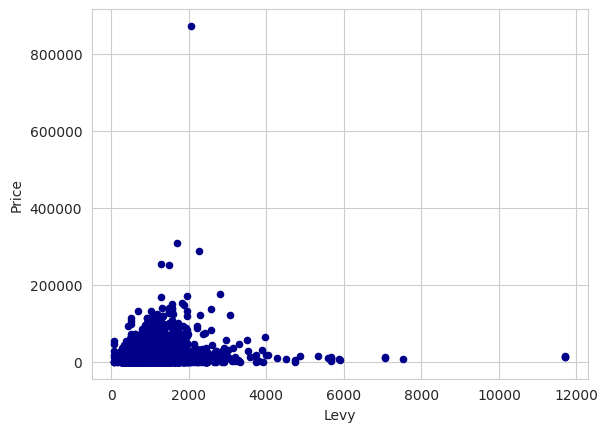

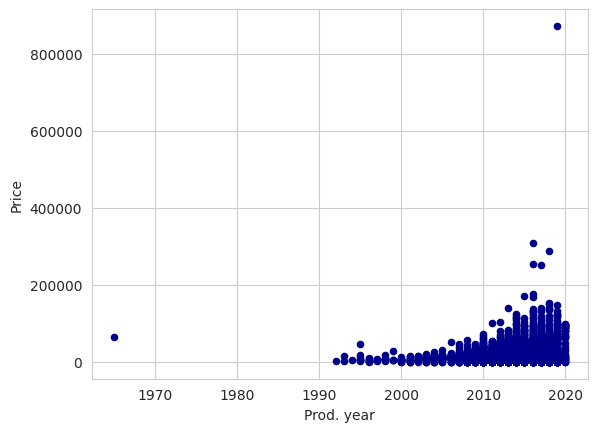

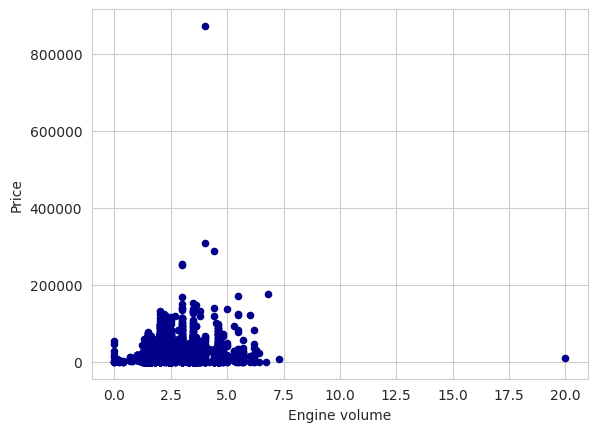

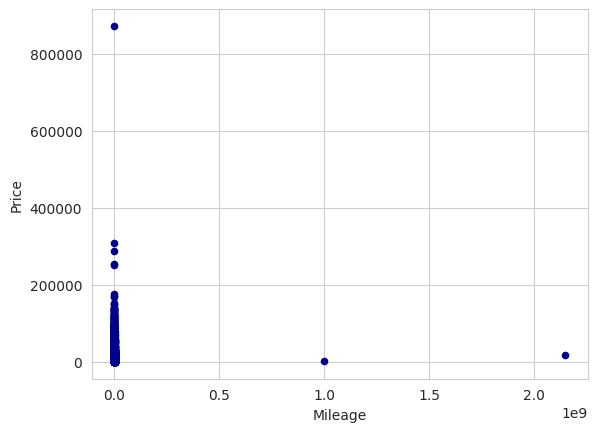

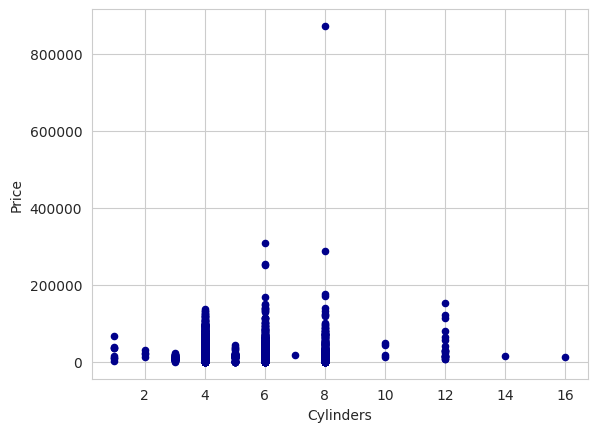

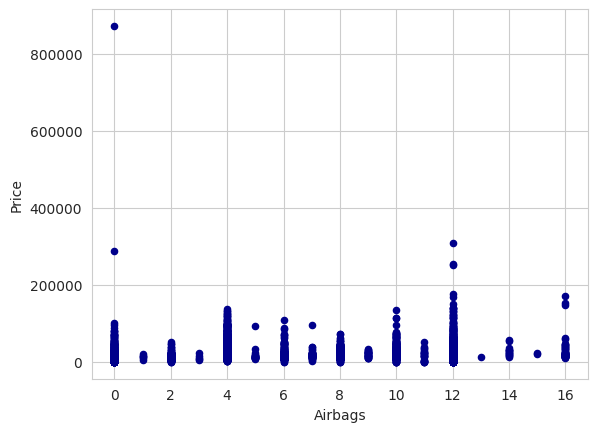

In [20]:

num_columns = ["Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]
cat_columns = ["Manufacturer", "Model", "Category", "Leather interior", "Fuel type", "Gear box type", "Drive wheels", "Wheel", "Color", "Doors"]
response_var = "Price"

df_buff = df_src[(df_src["Price"] > 850) & (df_src["Price"] < 30000)]
for cat_col_i in cat_columns:
    # Что-то не работает с производителями и моделями...
    if(cat_col_i != "Manufacturer" and cat_col_i != "Model"):
        data_wide = df_buff.pivot(columns=cat_col_i, values=response_var)
        # df_buff.pivot делает новую таблицу, где:
        # Категории из cat_col_i становятся столбцами
        # Каждая i строка имеет все NaN, кроме того столбца, где на i-ой строке в df_buff была именна эта категория,
        # и в этом столбце, где не NaN будет стоять цена на i-ой строке в df_buff
        data_wide.plot.kde(figsize = (8, 6), linewidth = 4)
        # kde - это диаграмма плотности

for num_col_i in num_columns:
    df_nums.plot.scatter(x=num_col_i, y=response_var, c="DarkBlue")
    

<Figure size 1000x1000 with 0 Axes>

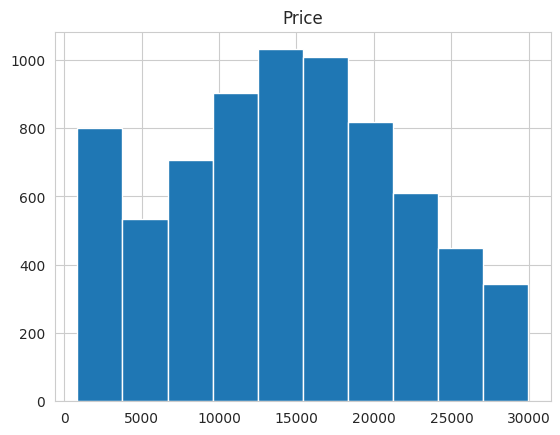

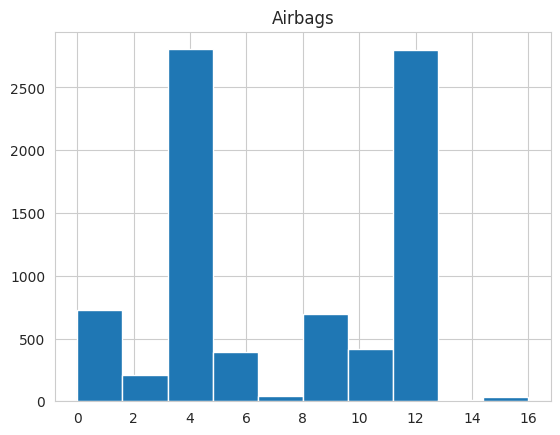

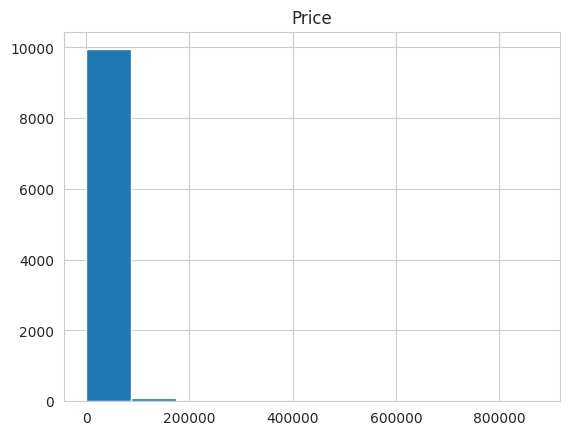

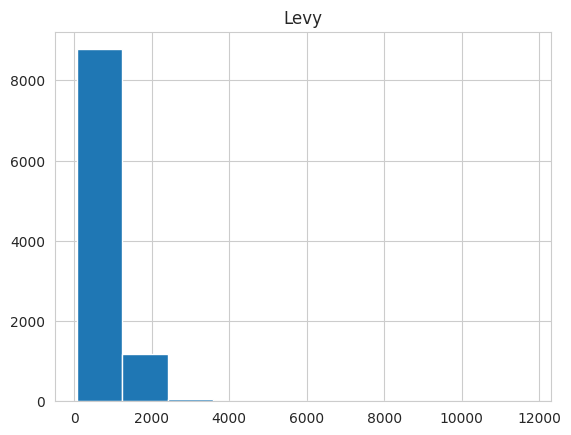

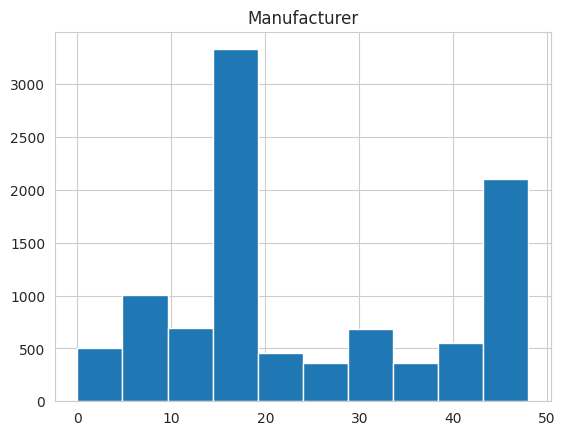

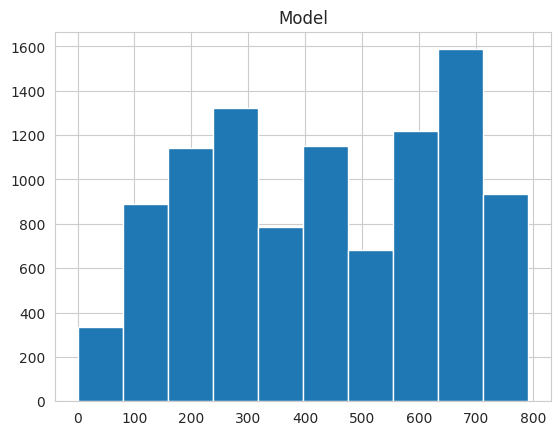

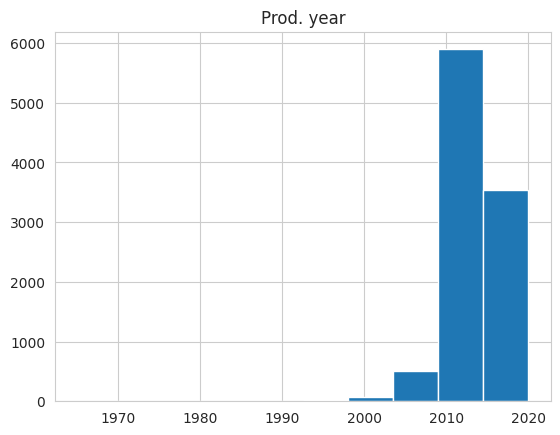

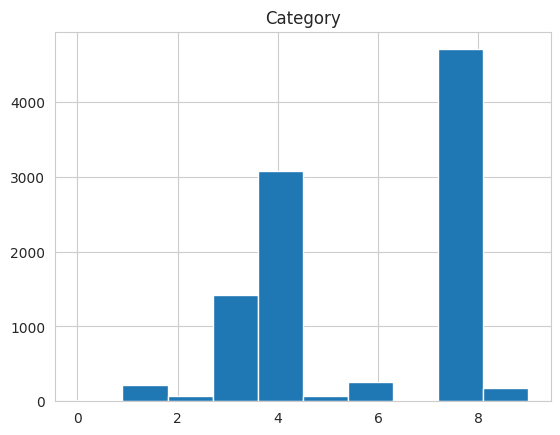

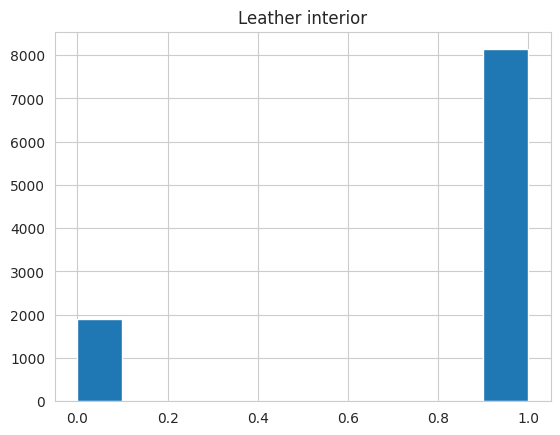

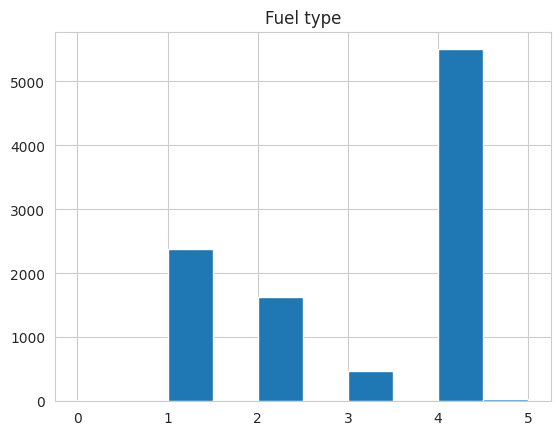

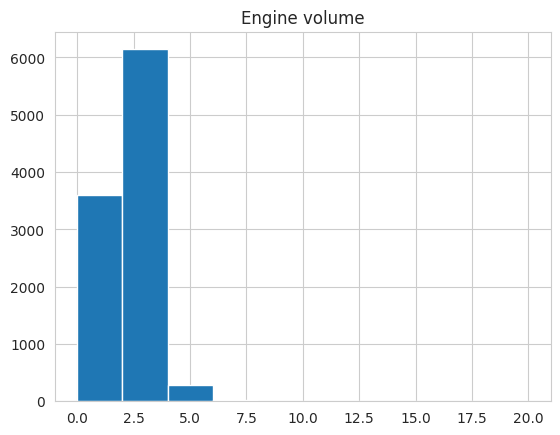

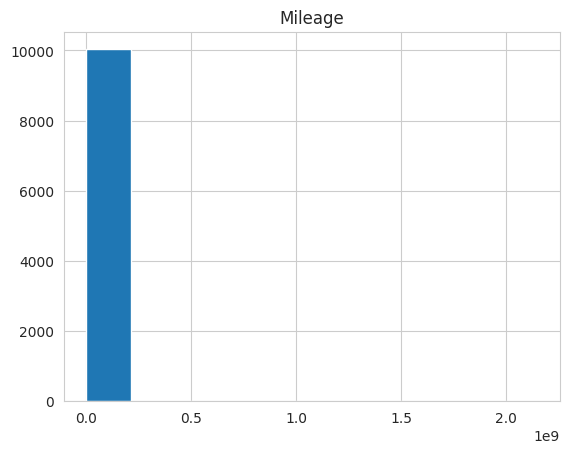

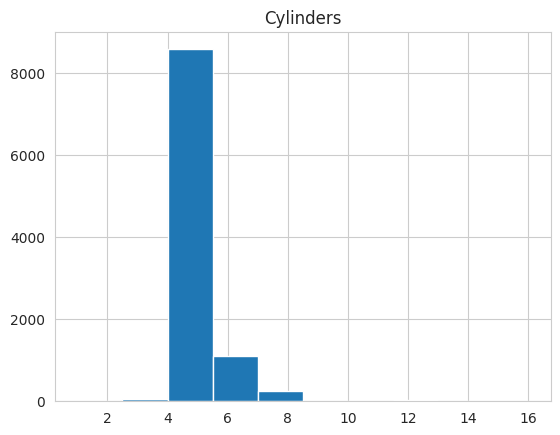

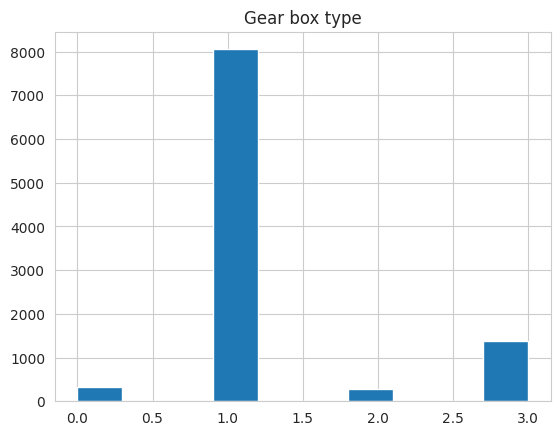

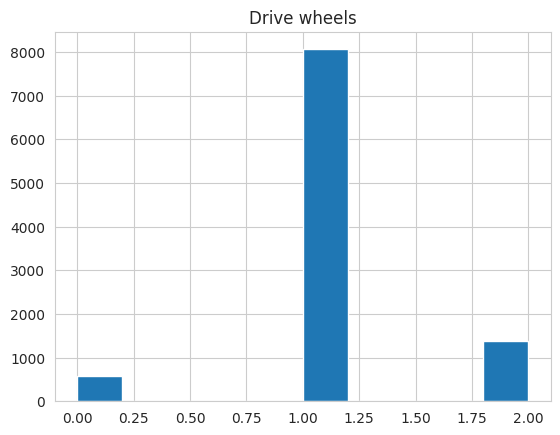

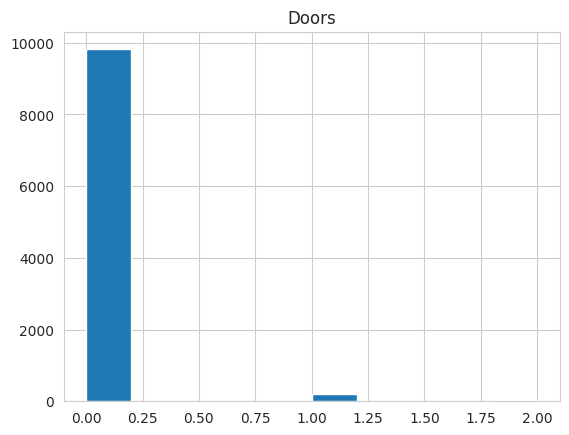

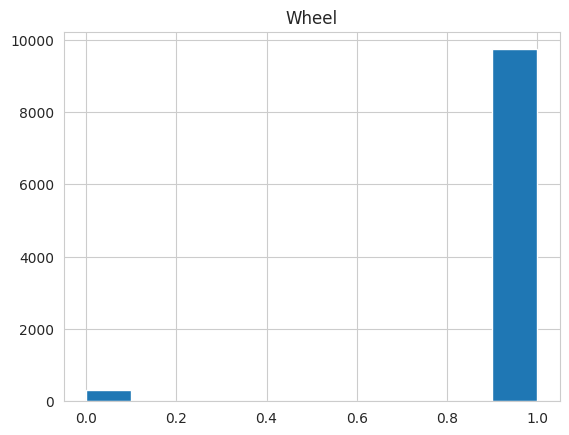

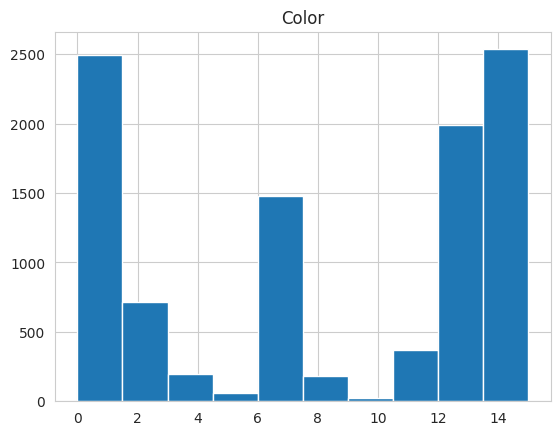

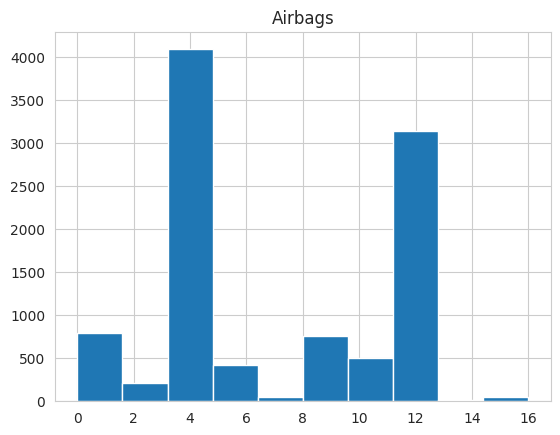

In [24]:
# Гистограммы

plt.figure(figsize=(10, 10))

df_src[(df_src["Price"] > 850) & (df_src["Price"] < 30000)].hist(column="Price")
df_src[(df_src["Price"] < 30000)].hist(column="Price")

cols = df_nums.columns
for col_i in cols:
    df_nums.hist(column=col_i)


# Регрессия

In [22]:
# coming soon...
